In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset, random_split
import pdb

In [6]:
fileDirArr = ['MHD_beta1','MHD_beta10','MHD_beta100']
field_list = ['density']

# For a given field...
# read in npy files under each file directory
for field in field_list:
    lbl = 0
    for fileDir in fileDirArr:
        filename = f"/data_{fileDir}_{field}.npy"
        x = np.load('Files/' + fileDir + filename) # the images
        if (lbl==0):
            x_full = x
        # assign a class value to each image depending on which        simulation it came from
        # (e.g. 0 for beta = 1, 1 for beta = 10, 2 for beta = 100)
        xshape = x.shape
        y = np.ones(xshape[2])*lbl # label these images by lbl
        if (lbl==0):
            y_full = y

        # pdb.set_trace()
        x_full = np.concatenate([x_full,x],axis=2)
        y_full = np.concatenate([y_full,y])

        lbl+=1


In [95]:
# convert to torch tensors and combine labels, features into TensorDataset
# Need to add a channel column?
x_shape = x_full.shape
print(x_shape)

# x needs to have a channel column, i.e. x will be in format (N,C,H,W)
# x and y need to have the same first dimension 
x_with_channel = (torch.Tensor(x_full).permute(2,0,1))
x_channel_shape = x_with_channel.shape
x_with_channel = x_with_channel.reshape(-1,1,x_channel_shape[1],x_channel_shape[2])
print(x_with_channel.shape)

x_full_permute = torch.Tensor(x_with_channel) 
print(x_full_permute.shape)
y_full = torch.Tensor(y_full)
y_full = y_full.type(torch.LongTensor)
print(y_full.shape)


(128, 128, 131072)
torch.Size([131072, 1, 128, 128])
torch.Size([131072, 1, 128, 128])
torch.Size([131072])


In [96]:
full_data = TensorDataset(x_full_permute,y_full)

In [97]:
# split into training (60%), validation (20%), and test (20%) sets
train_data,val_data,test_data = random_split(full_data,[0.6,0.2,0.2])
print(f"Length of Training Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")
print(f"Length of Test Data : {len(test_data)}")

Length of Training Data : 78644
Length of Validation Data : 26214
Length of Test Data : 26214


In [98]:
# assign some label names
labels_map = {
    0: r"$\beta \sim 1$",
    1: r"$\beta \sim 10$",
    2: r"$\beta \sim 100$",
}

In [99]:
# load batches of training and validation data
# the validation data batch size is twice as large because no backprop is needed

batch_size=64

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
valid_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)

At this point, its worth it to show a few images and make sure we haven't messed anything up.

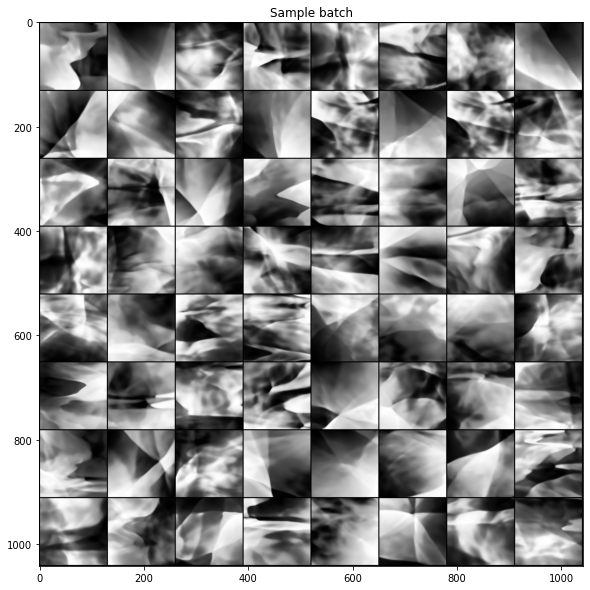

In [53]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

"""
figure = plt.figure(figsize=(8, 8))
cols, rows = int(batch_size/2.), int(batch_size/2.)
for i, data in enumerate(train_dl):
    #pdb.set_trace()
    img, label = data 
    img = img.numpy().squeeze(-1)
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    pdb.set_trace()
    if (label[i] == 0):
        plt.imshow(img[i,:,:], cmap="gray")
    if (label[i] == 1):
        plt.imshow(img[i,:,:], cmap="Blues")
    if (label[i] == 2):
        plt.imshow(img[i,:,:], cmap="Greens")
"""
def imshow(img, title):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose( img.numpy(), (1, 2, 0)), cmap='gray')
    plt.show()

for i, data in enumerate(train_dl):
    x, y = data  
    imshow(make_grid(x, 8), title = 'Sample batch')
    break  # we need just one batch


In [100]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

In [106]:
 # create a CNN using the built-in Sequential class

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(4), # works with any input size
    nn.Flatten(),
    nn.Linear(16*4*4,3)
)
 
"""
model =nn.Sequential(
    nn.Conv2d(1,128,kernel_size=3,padding=1),
    nn.ReLU(),
    nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),

    nn.Flatten(),
    nn.Linear(128*4*4,512),
    nn.ReLU(),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Linear(256,3)
)
"""
# create a loss function and optimizer
lr = 0.001
mmtm = 0.9

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(),
                            lr=lr,momentum=mmtm)

In [107]:
# run the model
epochs = 100
fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

KeyboardInterrupt: 